In [1]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.3.0
PyG version 2.5.3


In [2]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [3]:
#@title [RUN] Helper functions for data preparation

class SetTarget(object):
    """
    This transform mofifies the labels vector per data sample to only keep 
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target  
        data.y = data.y[:, target]
        return data


class CompleteGraph(object):
    """
    This transform adds all pairwise edges into the edge index per data sample, 
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

In [4]:
#@title [RUN] Helper functions for visualization

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H", 
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

In [5]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

In [6]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    path = './qm9'
    target = 0

    # Transforms which are applied during data loading:
    # (1) Fully connect the graphs, (2) Select the target/label
    transform = T.Compose([CompleteGraph(), SetTarget()])
    
    # Load the QM9 dataset with the transforms defined
    dataset = QM9(path, transform=transform)

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()

C:\Users\loris\anaconda3\envs\100jML\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


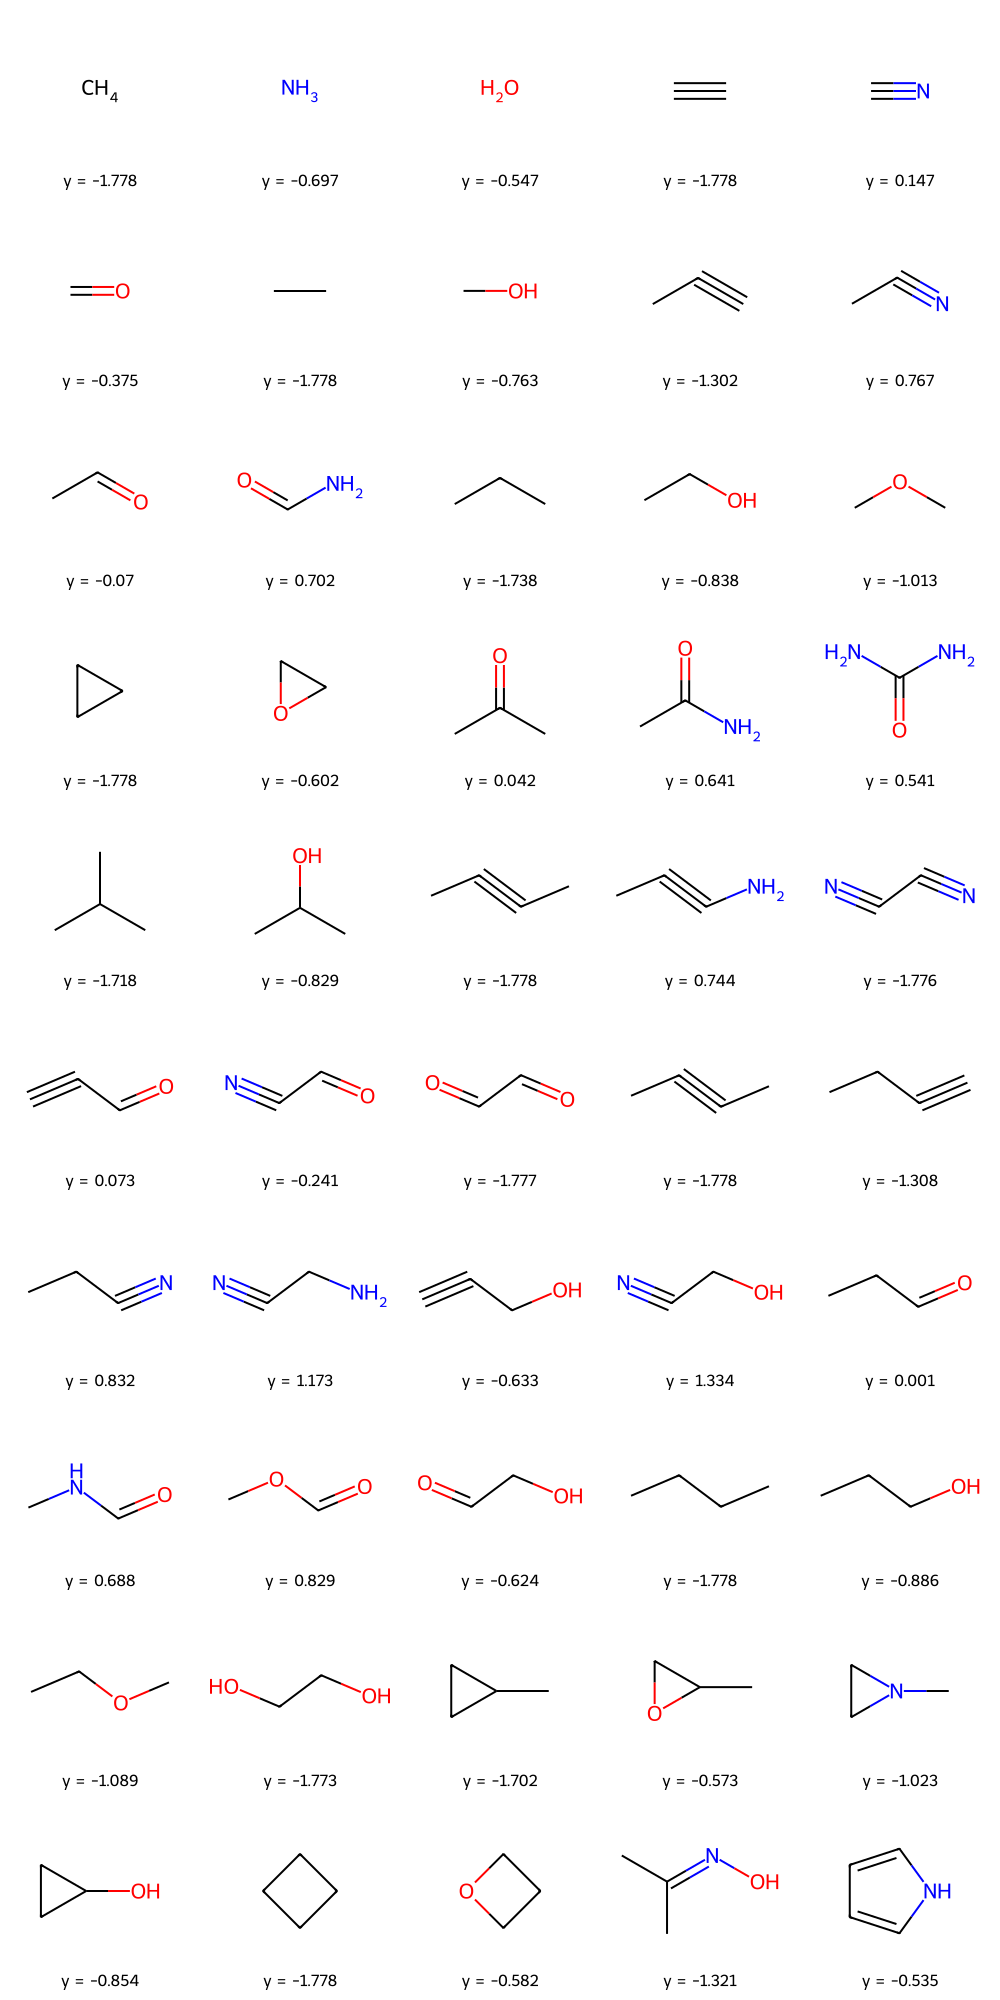

In [8]:
num_viz = 50
mols = [to_rdkit(train_dataset[i]) for i in range(num_viz)]
values = [str(round(float(train_dataset[i].y), 3)) for i in range(num_viz)]

Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

In [9]:
data = train_dataset[0] # one data sample, i.e. molecular graph
print("Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:")
print(data)

Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:
Data(x=[5, 11], edge_index=[2, 20], edge_attr=[20, 4], y=[1], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


In [10]:
print(f"\nThis molecule has {data.x.shape[0]} atoms, and {data.edge_attr.shape[0]} edges.")

print(f"\nFor each atom, we are given a feature vector with {data.x.shape[1]} entries (described above).")

print(f"\nFor each edge, we are given a feature vector with {data.edge_attr.shape[1]} entries (also described above).")

print(f"\nIn the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.")

print(f"\nEach atom also has a {data.pos.shape[1]}-dimensional coordinate associated with it. We will talk about their importance later in the practical.")

print(f"\nFinally, we have {data.y.shape[0]} regression target for the entire molecule.")


This molecule has 5 atoms, and 20 edges.

For each atom, we are given a feature vector with 11 entries (described above).

For each edge, we are given a feature vector with 4 entries (also described above).

In the next section, we will learn how to build a GNN in the Message Passing flavor to process the node and edge features of molecular graphs and predict their properties.

Each atom also has a 3-dimensional coordinate associated with it. We will talk about their importance later in the practical.

Finally, we have 1 regression target for the entire molecule.


In [11]:
# Toy graph 1
edge_index_1 = torch.tensor(
    [[0, 1, 1, 2], [1, 0, 2, 1]], 
    dtype=torch.long
)
x_1 = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data_1 = Data(x=x_1, edge_index=edge_index_1)

# Toy graph 2
edge_index_2 = torch.tensor(
    [[0, 2, 1, 0], [2, 0, 0, 1]], 
    dtype=torch.long
)
x_2 = torch.tensor([[1], [0], [-1]], dtype=torch.float)

data_2 = Data(x=x_2, edge_index=edge_index_2)

# Create batch from toy graphs
data_list = [data_1, data_2]
batch = Batch.from_data_list(data_list)

assert (batch[0].x == data_1.x).all() and (batch[1].x == data_2.x).all()

# Create DataLoader
loader = DataLoader(data_list, batch_size=1, shuffle=False)
it = iter(loader)
batch_1 = next(it)
batch_2 = next(it)

assert (batch_1.x == data_1.x).all() and (batch_2.x == data_2.x).all()

In [12]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the 
        message passing procedure: `message()` -> `aggregate()` -> `update()`.
        
        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`, 
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j 
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take 
        any arguments that were initially passed to `propagate`. Additionally, 
        we can differentiate destination nodes and source nodes by appending 
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`. 
        
        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features
        
        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`, 
        as well as any optional arguments that were initially passed to 
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:56: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
C:\Users\loris\AppData\Local\Temp\ipykernel_21748\626594273.py:3: SyntaxWarning: invalid escape sequence '\o'
  """Message Passing Neural Network Layer
C:\Users\loris\AppData\Local\Temp\ipykernel_21748\626594273.py:56: SyntaxWarning: invalid escape sequence '\p'
  """Step (1) Message
C:\Users\loris\AppData\Local\Temp\ipykernel_21748\626594273.py:99: SyntaxWarning: invalid escape sequence '\p'
  """


In [15]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [16]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.pos = data.pos[perm]
    data.z = data.z[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note: 
    # (1) While we originally defined the permutation matrix P as only having 
    #     entries 0 and 1, its implementation via `perm` uses indexing into 
    #     torch tensors, instead. 
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant 
    #     dummy values. For any experiments beyond unit testing, all GNN models 
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is 
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is 
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

In [17]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

Is MPNNModel permutation invariant? --> True!
Is MPNNLayer permutation equivariant? --> True!


In [18]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

In [19]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for MPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
MPNNModel(
  (lin_in): Linear(in_features=11, out_features=64, bias=True)
  (convs): ModuleList(
    (0-3): 4 x MPNNLayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 103233

Start training:
Epoch: 010, LR: 0.000900, Loss: 0.4569438, Val MAE: 0.9021258, Test MAE: 0.7487987
Epoch: 020, LR: 0.000810, Loss: 0.4050993, Val MAE: 0.9816230, Test MAE: 0.7487987
Epoch: 030, LR: 0.000729, Loss: 0.3745638, Val MAE: 1.0400932, Test MAE: 0.7192456
Epoch: 040, LR: 0.000590, Loss: 0.3126495, Val MAE: 1.0237188, Test MAE: 0.7192456
Epoch: 050, LR: 0.000478, Loss: 0.2480720, Val MAE: 1.2101796, Test MAE: 0.7192456
Epoch: 060, LR: 0.000430, Loss: 0.2021067, Val MAE: 0.9518923, Test MAE: 0.7192456
Epoch: 070, LR: 0.000349, Loss: 0.1538585, Val MAE: 1.1333042, Test MAE: 0.7192456
Epoch: 080, LR: 0.000282, Loss: 0.1133856, Val MAE: 0.9653191, Test

AttributeError: 'DataFrame' object has no attribute 'append'

In [20]:
RESULTS

{'MPNNModel': (0.8894417114257812, 0.7192456135749817, 1.546276903152466)}

In [22]:
DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)

C:\Users\loris\AppData\Local\Temp\ipykernel_21748\4278934082.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  DF_RESULTS = pd.concat([DF_RESULTS, df_temp], ignore_index=True)


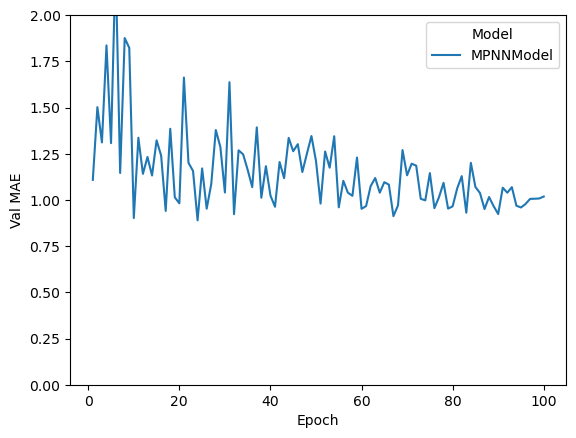

In [23]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

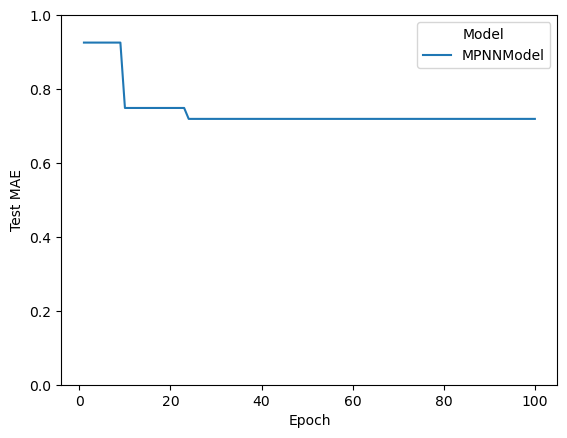

In [24]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));